## DATATHON PROJECT

Contributer: Jinran Jin, Peng Zhao, Melissa Tam

### Introduction

When doing data analysis, the size of the data we use is crucial to the overall accuracy of the models. There are lots of method to augment the data we train. For example, bootstraping. This is a way to create multiple samples from the origianl dataset. But the data we got form bootsraping are still from the real dataset. However, there are drawbacks related to this method. If we have a relatively small dataset, this might not be helpful. This could also lead to underestimation of variablity. Here we are presenting a whole new way of bootstraping, using GAN to generate "fake" data based on training data. Therefore we can hopfully capture the hidden feature behind the "real data" and ultimately increase the robustness of the training dataset. 

### Preprocessing and Package Loading

In [25]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


### Logistic Regresssion and SVM for Benchmark

#### Logistic Regression

In [5]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')['quality'].values
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')['quality'].values

In [6]:
logreg = LogisticRegression(random_state=16, max_iter=6000)
logreg.fit(X_train, y_train)
logreg.score(X_test,y_test)

c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5953125

#### SVM

In [7]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

accuracy: 0.6109375


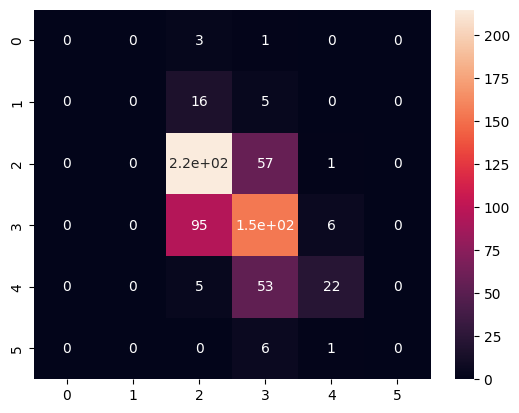

In [8]:
y_test_predict = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)
print('accuracy:', accuracy_score(y_test, y_test_predict))

### GAN

Setting device

In [9]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3070


dataset

In [10]:
class wineDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx]
        return features

dataloader

In [11]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

train = pd.concat([X_train, y_train], axis=1)
size = train.shape[0]
scaler = StandardScaler()
scaler.fit(train)
train_scale = scaler.transform(train)

train_dataloader = DataLoader(wineDataset(train_scale), batch_size=size, shuffle=True)
next(enumerate(train_dataloader))[1][0]

tensor([ 1.3005, -1.6434,  0.7962, -0.5473, -0.1944, -0.9742, -0.7385,  0.5008,
        -0.6828,  2.3989,  0.3007,  1.6882], dtype=torch.float64)

define model

In [12]:
noise_len = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_len, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 12),
            nn.ReLU()
        )

    def forward(self, input):
        return self.gen(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
    def forward(self, input):
        return self.dis(input)

training loop

In [13]:
netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

real_label = torch.ones((size, 1), dtype=torch.float32, device=device)
fake_label = torch.zeros((size, 1), dtype=torch.float32, device=device)

G_losses = []
D_losses = []

Discriminator

In [ ]:
for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader):
        
        # real data
        netD.zero_grad()
        data = data.to(torch.float32).to(device)
        
        output = netD(data)

        errD_real = criterion(output, real_label)
        errD_real.backward()
        D_x = output.mean().item()

        # fake data
        noise = torch.randn(size, noise_len, device=device)
        fake = netG(noise)
        
        output = netD(fake)

        errD_fake = criterion(output, fake_label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        D_losses.append(errD.item())
        
    if epoch % 5 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tReal mean: %.4f\tFake mean: %.4f' % (epoch, num_epoch, errD.item(), D_x, D_G_z1))

Generator 

In [ ]:
for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader, 0):

        netG.zero_grad()
        
        noise = torch.randn(size, noise_len, device=device)
        fake = netG(noise)
        output = netD(fake)
        
        errG = criterion(output, real_label)
        errG.backward()
        
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())

    if epoch % 5 == 0:
        print('[%d/%d]\tLoss_G: %.4f\tFake mean: %.4f' % (epoch, num_epoch, errG.item(), D_G_z2))





In [18]:
#loading the trained model and generating the fake data
netD = Discriminator().to(device)
netD.load_state_dict(torch.load('./model/netD_deep.pt'))

netG = Generator().to(device)
netG.load_state_dict(torch.load('./model/netG_deep.pt'))

<All keys matched successfully>

Generating 3000 data with GAN

In [20]:
with torch.no_grad():
    noise = torch.randn(3000, noise_len, device=device)
    fake = netG(noise).cpu()
    fake = scaler.inverse_transform(fake)

fake = pd.DataFrame(fake).round(3)
fake.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,8.668,0.526,0.269,2.519,0.086,15.836,50.803,0.997,3.325,0.667,10.651,5.850
1,8.729,0.526,0.267,2.605,0.087,15.836,48.423,0.997,3.317,0.684,10.475,5.713
2,8.509,0.526,0.267,2.519,0.086,15.836,47.771,0.997,3.324,0.664,10.570,5.768
3,8.303,0.526,0.267,2.519,0.086,15.836,46.204,0.997,3.333,0.660,10.567,5.679
4,8.601,0.526,0.272,2.519,0.086,15.836,49.937,0.997,3.325,0.680,10.519,5.939
5,8.284,0.526,0.267,2.519,0.086,15.836,46.204,0.997,3.317,0.681,10.475,5.758
6,9.003,0.533,0.267,2.519,0.086,15.836,47.392,0.997,3.331,0.666,10.637,5.810
7,8.841,0.529,0.267,2.519,0.086,15.836,46.204,0.997,3.318,0.667,10.629,5.747
8,8.596,0.526,0.267,2.519,0.086,15.836,49.932,0.997,3.322,0.678,10.495,5.724
9,8.451,0.526,0.267,2.519,0.086,15.836,46.204,0.997,3.333,0.669,10.651,5.815


### Test with augmented data

In [22]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')['quality'].values
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')['quality'].values
X_fake = fake.iloc[:, 0:11]
y_fake = fake.iloc[:, 11].round().clip(3, 8)
X_aug = np.concatenate((X_fake.values, X_train.values))
y_aug = np.concatenate((y_fake, y_train))

fitting model with augmented data

In [23]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_aug, y_aug)

logreg = make_pipeline(StandardScaler(), LogisticRegression(random_state=16, max_iter=6000))
logreg.fit(X_aug, y_aug)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=6000, random_state=16))])

Accuracy with augmented data

c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


auc svm: 0.7586520481940772
accuracy svm: 0.628125


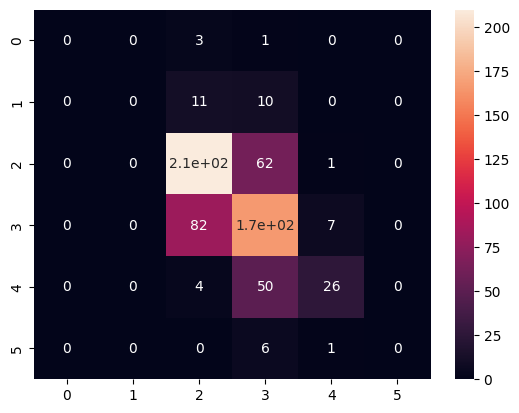

log auc: 0.7838820173056681
log accuracy: 0.5640625


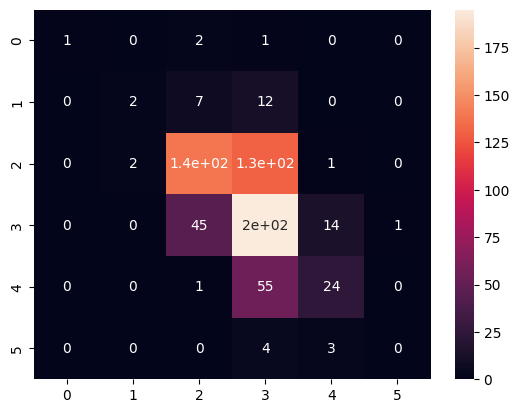

In [26]:
y_test_predict = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

y_test_predict_log = logreg.predict(X_test)
y_test_pred_prob_log = logreg.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)

print('auc svm:', roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr'))
print('accuracy svm:', accuracy_score(y_test, y_test_predict))
plt.show()

sns.heatmap(confusion_matrix(y_test, y_test_predict_log), annot=True)

print('log auc:', roc_auc_score(y_test, y_test_pred_prob_log, multi_class='ovr'))
print('log accuracy:', accuracy_score(y_test, y_test_predict_log))

### Discussion

As we can see here, we got a higher accuracy for SVM from our augmented data. For the logistic regression, the accuracy slightly dropped by 0.02. This might because our generated data was not accurate and can not be representitive for the entire population. It might also becasue the formula for logistic regression is different to SVM which can results in different result. 

For SVM our 3000 generated data was indeed helpful for the accuracy. Which is a better solution to the lacking data proble compared to the traditional bootstraping. However, the improvement was not significant enough to say that our method is better than using the orignal dataset. By using different model Architecture or trying out different training method might lead to a better result. 

### Conclusion

To conclude, in this work, we demonstrated a new way of data augmentation for traditional statistical models like logistic regression and SVM. By doing so we provide a new direction of further studies to find a better deep learning model like GAN to generate better data for bootstrapping. 